In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset



tf.logging.set_verbosity(tf.logging.ERROR)
# pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

titanic_dataframe = pd.read_csv("titanic/train.csv", sep=",")

titanic_dataframe = titanic_dataframe.reindex(
    np.random.permutation(titanic_dataframe.index))

titanic_dataframe.describe()

# titanic_dataframe = titanic_dataframe[titanic_dataframe["TotRmsAbvGrd"] <= 13]
# titanic_dataframe = titanic_dataframe[titanic_dataframe["OverallQual"] <= 9.5]
# titanic_dataframe = titanic_dataframe[titanic_dataframe["GrLivArea"] <= 3500]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0,891.0,891.0,714.0,891.0,891.0,891.0
mean,446.0,0.4,2.3,29.7,0.5,0.4,32.2
std,257.4,0.5,0.8,14.5,1.1,0.8,49.7
min,1.0,0.0,1.0,0.4,0.0,0.0,0.0
25%,223.5,0.0,2.0,20.1,0.0,0.0,7.9
50%,446.0,0.0,3.0,28.0,0.0,0.0,14.5
75%,668.5,1.0,3.0,38.0,1.0,0.0,31.0
max,891.0,1.0,3.0,80.0,8.0,6.0,512.3


In [2]:



# titanic_dataframe["Cabin"].notnull().sum()

In [3]:
def preprocess_features(titanic_dataframe, drop):#, features):
  """Prepares input features from California housing data set.

  Args:
    titanic_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  correlation_dataframe = titanic_dataframe.copy()
  correlation_dataframe["target"] = correlation_dataframe["Survived"]
  if drop:#creat drop function
    plt.scatter(correlation_dataframe['Age'], correlation_dataframe["target"])

    correlation_dataframe = correlation_dataframe.dropna(subset = ['Age'])# correlation_dataframe['Age'].dropna()
    correlation_dataframe = correlation_dataframe.drop(['Cabin'], axis=1)# correlation_dataframe['Fare'].dropna()
    correlation_dataframe = correlation_dataframe.dropna(subset = ['Embarked'])

  new = pd.DataFrame(correlation_dataframe)#.copy#.corr()
  new = pd.concat([correlation_dataframe, pd.get_dummies(correlation_dataframe['SibSp']).rename(columns={0:"SS0", 1:'SS1', 2:'SS2'}),
                 pd.get_dummies(correlation_dataframe['Parch']).rename(columns={0:"PC0", 1:'PC1', 2:'PC2'}),
                 pd.get_dummies(correlation_dataframe['Sex']), pd.get_dummies(correlation_dataframe['Embarked']),
                pd.get_dummies(correlation_dataframe['Pclass']).rename(columns={1:'Class1', 2:'Class2', 3:"Class3"})],
                axis=1)

  print(new.head(7))


  new1 = new.corr()
  features_i = new1['target'].sort_values(ascending=False).head(10)
#   features_i

  # new.hist(figsize=(20,20))
  # print(features)
  features_index = features_i.index
  print("\nChosen Features NULLs?\n\n", new[features_index].isnull().sum())

  selected_features = new[features_index]
  processed_features = selected_features.copy()

  return processed_features

def preprocess_targets(titanic_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    titanic_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets["Survived"] = titanic_dataframe["Survived"]
  return output_targets
# titanic_dataframe

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(titanic_dataframe.head(691), 0)
training_targets = preprocess_targets(titanic_dataframe.head(691))
#
# correlation_dataframe = titanic_dataframe.copy()
# correlation_dataframe["target"] = training_targets["SalePrice"]
# new = correlation_dataframe.corr()
# print(new)
# features1 = new['target'].sort_values(ascending=False).head(10).index
# features1 = features1[2:-1]
# #
# training_examples = preprocess_features(titanic_dataframe.head(1000), features1)

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(titanic_dataframe.tail(460), 0)#, features1)
validation_targets = preprocess_targets(titanic_dataframe.tail(460))

# display.display(titanic_dataframe.describe())

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())


     PassengerId  Survived  Pclass  \
150          151         0       2   
148          149         0       2   
412          413         1       1   
709          710         1       3   
707          708         1       1   
744          745         1       3   
279          280         1       3   

                                                  Name     Sex  Age  SibSp  \
150                         Bateman, Rev. Robert James    male 51.0      0   
148           Navratil, Mr. Michel ("Louis M Hoffman")    male 36.5      0   
412                             Minahan, Miss. Daisy E  female 33.0      1   
709  Moubarek, Master. Halim Gonios ("William George")    male  nan      1   
707                  Calderhead, Mr. Edward Pennington    male 42.0      0   
744                                 Stranden, Mr. Juho    male 31.0      0   
279                   Abbott, Mrs. Stanton (Rosa Hunt)  female 35.0      1   

     Parch             Ticket  Fare   ...     4   5  female  male   C 

,Survived,target,female,Class1,Fare,SS1,PC1,C,Class2,Parch
count,691.0,691.0,691.0,691.0,691.0,691.0,691.0,691.0,691.0,691.0
mean,0.4,0.4,0.4,0.3,32.7,0.2,0.1,0.2,0.2,0.4
std,0.5,0.5,0.5,0.4,51.7,0.4,0.3,0.4,0.4,0.8
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,7.9,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,14.5,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,31.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,512.3,1.0,1.0,1.0,1.0,5.0


Validation examples summary:


,Survived,target,female,Class1,Fare,C,SS1,PC1,PC2,Parch
count,460.0,460.0,460.0,460.0,460.0,460.0,460.0,460.0,460.0,460.0
mean,0.4,0.4,0.3,0.3,29.9,0.2,0.2,0.1,0.1,0.4
std,0.5,0.5,0.5,0.4,37.1,0.4,0.4,0.3,0.3,0.8
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,7.9,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,14.5,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,32.4,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,263.0,1.0,1.0,1.0,1.0,6.0


Training targets summary:


,Survived
count,691.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,Survived
count,460.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


In [5]:
# #find good feratures based on sale price
# correlation_dataframe = titanic_dataframe.copy()
# correlation_dataframe["target"] = titanic_dataframe["SalePrice"]

# # display.display(training_targets.describe())

# correlation_dataframe.corr()
# new = pd.DataFrame()
# new['target'] = correlation_dataframe.corr()['target']
# new.to_csv('corr.csv')
# # correlation_dataframe["OpenPorchSF"].corr()

In [6]:
# correlation_dataframe = titanic_dataframe.copy()
# correlation_dataframe["target"] = training_targets["SalePrice"]

# # display.display(training_targets.describe())
# # pd.options.display.max_rows = 20

# new = correlation_dataframe.corr()
# print(new['target'].sort_values(ascending=False).head(10))#.index)


In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels


In [8]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [9]:
# def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
#   """A custom input_fn for sending MNIST data to the estimator for training.

#   Args:
#     features: The training features.
#     labels: The training labels.
#     batch_size: Batch size to use during training.

#   Returns:
#     A function that returns batches of training features and labels during
#     training.
#   """
#   def _input_fn(num_epochs=None, shuffle=True):
#     # Input pipelines are reset with each call to .train(). To ensure model
#     # gets a good sampling of data, even when number of steps is small, we 
#     # shuffle all the data before creating the Dataset object
#     idx = np.random.permutation(features.index)
#     raw_features = {"pixels":features.reindex(idx)}
#     raw_targets = np.array(labels[idx])
   
#     ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
#     ds = ds.batch(batch_size).repeat(num_epochs)
    
#     if shuffle:
#       ds = ds.shuffle(10000)
    
#     # Return the next batch of data.
#     feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
#     return feature_batch, label_batch

#   return _input_fn

In [10]:
# def create_predict_input_fn(features, labels, batch_size):
#   """A custom input_fn for sending mnist data to the estimator for predictions.

#   Args:
#     features: The features to base predictions on.
#     labels: The labels of the prediction examples.

#   Returns:
#     A function that returns features and labels for predictions.
#   """
#   def _input_fn():
#     raw_features = {"pixels": features.values}
#     raw_targets = np.array(labels)
    
#     ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
#     ds = ds.batch(batch_size)
    
        
#     # Return the next batch of data.
#     feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
#     return feature_batch, label_batch

#   return _input_fn

In [11]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [12]:
def train_linear_classification_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, and a confusion
  matrix.
  
  Args:
    learning_rate: An `int`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `LinearClassifier` object.
  """

  periods = 10

  steps_per_period = steps / periods  
  # Create the input functions.
#   predict_training_input_fn = create_predict_input_fn(
#     training_examples, training_targets, batch_size)
#   predict_validation_input_fn = create_predict_input_fn(
#     validation_examples, validation_targets, batch_size)
#   training_input_fn = create_training_input_fn(
#     training_examples, training_targets, batch_size)
  
  # Create a LinearClassifier object.
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      n_classes=10,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["Survived"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["Survived"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Survived"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

In [13]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `titanic_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps // periods

  my_feature = input_feature
  my_feature_data = titanic_dataframe[[my_feature]].astype('float32')
  my_label = "Survived"
  targets = titanic_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = titanic_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) // weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

In [ ]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
#     hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `titanic_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `titanic_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `titanic_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `titanic_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["SalePrice"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["SalePrice"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["SalePrice"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

     PassengerId  Survived  Pclass                                      Name  \
150          151         0       2                Bateman, Rev. Robert James   
148          149         0       2  Navratil, Mr. Michel ("Louis M Hoffman")   
412          413         1       1                    Minahan, Miss. Daisy E   
707          708         1       1         Calderhead, Mr. Edward Pennington   
744          745         1       3                        Stranden, Mr. Juho   
279          280         1       3          Abbott, Mrs. Stanton (Rosa Hunt)   
312          313         0       2     Lahtinen, Mrs. William (Anna Sylfven)   

        Sex  Age  SibSp  Parch             Ticket  Fare   ...     5   6  \
150    male 51.0      0      0        S.O.P. 1166  12.5   ...   0.0 0.0   
148    male 36.5      0      2             230080  26.0   ...   0.0 0.0   
412  female 33.0      1      0              19928  90.0   ...   0.0 0.0   
707    male 42.0      0      0           PC 17476  26.3   .

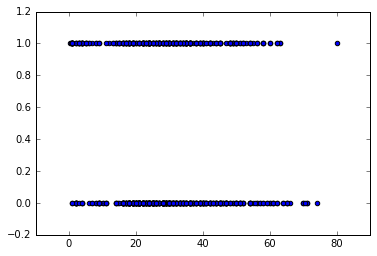

In [14]:
def normalize_linear_scale(examples_dataframe):#, features1):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #

#   clipped_feature = examples_dataframe["TotRmsAbvGrd"].apply(lambda x: min(x, 13))
#   examples_dataframe["TotRmsAbvGrd"] = clipped_feature
#   # titanic_dataframe = titanic_dataframe[titanic_dataframe["TotRmsAbvGrd"] <= 13]

#   clipped_feature = examples_dataframe["OverallQual"].apply(lambda x: min(x, 9.5))
#   examples_dataframe["OverallQual"] = clipped_feature
#   # titanic_dataframe = titanic_dataframe[titanic_dataframe["OverallQual"] <= 9.5]

#   clipped_feature = examples_dataframe["GrLivArea"].apply(lambda x: min(x, 3500)) #was max
#   examples_dataframe["GrLivArea"] = clipped_feature    
    
#   examples_dataframe = examples_dataframe[examples_dataframe["TotRmsAbvGrd"] <= 13]
#   examples_dataframe = examples_dataframe[examples_dataframe["OverallQual"] <= 9.5]
#   examples_dataframe = examples_dataframe[examples_dataframe["GrLivArea"] <= 3500]

#   examples_dataframe.dropna()

  new = pd.DataFrame()
  for i in examples_dataframe.columns:
#     print(examples_dataframe[i])
    new = pd.concat([new, linear_scale(examples_dataframe[i])], axis=1)

#   new = linear_scale(examples_dataframe[features1])
#   new["OverallQual"] = linear_scale(examples_dataframe["OverallQual"])
#   new["GrLivArea"] = linear_scale(examples_dataframe["GrLivArea"])
#   new["TotRmsAbvGrd"] = linear_scale(examples_dataframe["TotRmsAbvGrd"])
#   new["TotalBsmtSF"] = linear_scale(examples_dataframe["TotalBsmtSF"])
# #   new["1stFlrSF"] = linear_scale(examples_dataframe["1stFlrSF"])
# #   new["FullBath"] = linear_scale(examples_dataframe["FullBath"])
#   new["Fireplaces"] = linear_scale(examples_dataframe["Fireplaces"])
# #   new["GarageYrBlt"] = linear_scale(examples_dataframe["GarageYrBlt"])
# #   new["GarageCars"] = linear_scale(examples_dataframe["GarageCars"])
#   new["GarageArea"] = linear_scale(examples_dataframe["GarageArea"])
# #   new["SalePrice"] = examples_dataframe["SalePrice"]
  
  return new

##############
# clipped_feature = titanic_dataframe["TotRmsAbvGrd"].apply(lambda x: min(x, 13))
# titanic_dataframe["TotRmsAbvGrd"] = clipped_feature
# # titanic_dataframe = titanic_dataframe[titanic_dataframe["TotRmsAbvGrd"] <= 13]

# clipped_feature = titanic_dataframe["OverallQual"].apply(lambda x: min(x, 9.5))
# titanic_dataframe["OverallQual"] = clipped_feature
# # titanic_dataframe = titanic_dataframe[titanic_dataframe["OverallQual"] <= 9.5]

# clipped_feature = titanic_dataframe["GrLivArea"].apply(lambda x: min(x, 3500)) #was max
# titanic_dataframe["GrLivArea"] = clipped_feature
# titanic_dataframe = titanic_dataframe[titanic_dataframe["GrLivArea"] <= 3500]
###########

# def find_na(df):
#     l = []
#     for label in df.columns:
#         df.dropna()
# #         if df[label].dropna().shape[0] != df.shape[0]:
# #             l.append(label)
#     return df

normalized_dataframe = normalize_linear_scale(preprocess_features(titanic_dataframe, 1))#, features1)
# normalized_dataframe.dropna()
# print(normalized_dataframe.isnull().sum())
normalized_training_examples = normalized_dataframe.head(1000)
normalized_validation_examples = normalized_dataframe.tail(460)

print("YESSS\n", normalized_dataframe)
################################


# # clipped_feature = titanic_dataframe["TotRmsAbvGrd"].apply(lambda x: min(x, 13))
# # titanic_dataframe["TotRmsAbvGrd"] = clipped_feature

# # clipped_feature = titanic_dataframe["OverallQual"].apply(lambda x: min(x, 9.5))
# # titanic_dataframe["OverallQual"] = clipped_feature

# # clipped_feature = titanic_dataframe["GrLivArea"].apply(lambda x: max(x, 3500))
# # titanic_dataframe["GrLivArea"] = clipped_feature

# minimal_training_examples = training_examples[minimal_features]
# # clipped_feature = minimal_training_examples["TotRmsAbvGrd"].apply(lambda x: min(x, 13))
# # minimal_training_examples["TotRmsAbvGrd"] = clipped_feature

# clipped_feature = training_examples["OverallQual"].apply(lambda x: min(x, 9.5))
# training_examples["OverallQual"] = clipped_feature

# clipped_feature = training_examples["GarageArea"].apply(lambda x: min(x, 1000))
# training_examples["GarageArea"] = clipped_feature

# # clipped_feature = minimal_training_examples["GrLivArea"].apply(lambda x: max(x, 3500))
# # minimal_training_examples["GrLivArea"] = clipped_feature


# minimal_validation_examples = validation_examples[minimal_features]



In [16]:
# nn_regressor = train_nn_regression_model(
#     my_optimizer=tf.train.AdamOptimizer(learning_rate=0.005),
#     steps=2000,
#     batch_size=40,
#     hidden_units=[10, 4],
#     training_examples=minimal_training_examples,#normalized_training_examples,#minimal_training_examples,
#     training_targets=training_targets,
#     validation_examples=minimal_validation_examples,#normalized_validation_examples,#
#     validation_targets=validation_targets
# )

# With normalized values it is under 33, but is overfitting
# dnn_regressor, rsm, validation = train_nn_regression_model(
#     my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
#     steps=1000,
#     batch_size=10,
# #     hidden_units=[20],
#     training_examples=normalized_training_examples,#minimal_training_examples,#minimal_training_examples,
#     training_targets=training_targets,
#     validation_examples=normalized_validation_examples,#minimal_validation_examples,
#     validation_targets=validation_targets#validation_targets
# )
# classifier = train_linear_classification_model(
#              learning_rate=0.002,
#              steps=1000,
#              batch_size=10,
#              training_examples=training_examples,
#              training_targets=training_targets,
#              validation_examples=validation_examples,
#              validation_targets=validation_targets)

classifier = train_model(
             learning_rate=0.002,
             steps=1000,
             batch_size=10,
             training_examples=training_examples,
             training_targets=training_targets,
             validation_examples=validation_examples,
             validation_targets=validation_targets)

TypeError: train_model() got an unexpected keyword argument 'training_examples'

In [ ]:
# plt.scatter(training_examples["OverallQual"], training_targets["SalePrice"])
# plt.scatter(normalized_training_examples["OverallQual"], training_targets["SalePrice"])
plt.scatter(normalized_training_examples["GrLivArea"], training_targets["SalePrice"])
# plt.scatter(training_examples["TotalBsmtSF"], training_targets["SalePrice"])
# plt.scatter(normalized_training_examples["GarageArea"], training_targets["SalePrice"])
# plt.scatter(training_examples["GarageYrBlt"], training_targets["SalePrice"])
# training_examples["OverallQual"].hist()
# training_examples["GrLivArea"].hist()
# training_examples["TotalBsmtSF"].hist()
# training_examples["GarageArea"].hist()
# training_examples["GarageYrBlt"]#.hist()

_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [ ]:
california_housing_test_data = pd.read_csv("data/test.csv", sep=",")
california_housing_saleprice_data = pd.read_csv("data/sample_submission.csv", sep=",")

# inds = pd.isnull(california_housing_test_data).any().notnull()#.nonzero()[0]
# inds = np.where(california_housing_test_data.notnull())

# print(california_housing_test_data.notnull().sum())
# print(inds)
# california_housing_saleprice_data = california_housing_saleprice_data.iloc[california_housing_test_data.isnull().index()]
# california_housing_test_data = california_housing_test_data.dropna()#iloc[inds[0]]

# normalize_linear_scale(preprocess_features(titanic_dataframe))

print(california_housing_test_data)#.index.values
# california_housing_saleprice_data = california_housing_saleprice_data.iloc[inds[0]]
# for i in california_housing_test_data:
    
    
# print(california_housing_test_data.isnull().sum())

# california_housing_test_data = california_housing_test_data[california_housing_test_data["TotRmsAbvGrd"] <= 13]
# california_housing_test_data = california_housing_test_data[california_housing_test_data["OverallQual"] <= 9.5]
# california_housing_test_data = california_housing_test_data[california_housing_test_data["GrLivArea"] <= 3500]

new_examples = normalize_linear_scale(preprocess_features(california_housing_test_data))#.dropna()
new_targets = preprocess_targets(california_housing_saleprice_data)#.dropna())
# new_examples.fillna()
# print("YESSSSSSSS",new_examples.isnull().sum())
# # ### Double-check
# print("New examples summary:")
# display.display(new_examples.describe())
# print("New Targets summary:")
display.display(new_targets.describe())

# new_examples.drop(new_examples.index[[2577-1461,2121-1461]], inplace=True)
# new_targets.drop(new_targets.index[[2577-1461,2121-1461]], inplace=True)


# # new_examples.isnull().sum()
print(new_examples)
# # # new1.sort_values(ascending=True)

# new_examples.fillna(new_examples.mean())

predict_new_input_fn = lambda: my_input_fn(new_examples, new_targets["SalePrice"], num_epochs=1, shuffle=False)

new_predictions = dnn_regressor.predict(input_fn=predict_new_input_fn)
new_predictions = np.array([item['predictions'][0] for item in new_predictions])


#Obtain mean of columns as you need, nanmean is just convenient.
col_mean = np.nanmean(new_predictions, axis=0)
print("avg",col_mean)


#Find indicies that you need to replace
inds = np.where(np.isnan(new_predictions))
print(inds)

#Place column means in the indices. Align the arrays using take
new_predictions[inds] = [col_mean,col_mean]#np.take(col_mean, inds[1])
print("YES")
print(new_predictions)


# new_preditions=new_predictions[0:2577-1461] = 100

# new_predictions.fillna(new_predictions.mean())

# new_predictions = new_predictions[0:2121-1462]
# new_targets = new_targets[0:2121-1462]# = 100
# # new = pd.DataFrame()
# # new['SalePrice'] = 0
new = pd.DataFrame(new_predictions, columns=["SalePrice"])#[1], index=new_predictions[0])
print(new)
new.index.name = 'Id'
new_targets.index.name = 'Id'
new.rename({0:"SalePrice"})#, axis='columns')#[0].rename = 'SalePrice'
# pred = new
# new.index += 1461
# new["SalePrice"] *= 1000
# new.to_csv('predictions_60_rmse.csv')
# print(new.isnull().sum())
# print(pred)



new_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(pred, new_targets))

print("Final RMSE (on test data): %0.2f" % new_root_mean_squared_error)

In [ ]:
print(new_targets)
print(new)
plt.scatter(new_targets.index, new_targets["SalePrice"])

In [ ]:
plt.scatter(new.index, new["SalePrice"])

In [ ]:
# # titanic_dataframe["rooms_per_person"] = titanic_dataframe["total_rooms"] / titanic_dataframe["population"]

# calibration_data = train_model(
#     learning_rate=.5,
#     steps=500,
#     batch_size=5,
#     input_feature="OverallQual"
# )

In [ ]:
# def train_model(learning_rate, steps, batch_size, input_feature):
#   """Trains a linear regression model.
  
#   Args:
#     learning_rate: A `float`, the learning rate.
#     steps: A non-zero `int`, the total number of training steps. A training step
#       consists of a forward and backward pass using a single batch.
#     batch_size: A non-zero `int`, the batch size.
#     input_feature: A `string` specifying a column from `titanic_dataframe`
#       to use as input feature.
      
#   Returns:
#     A Pandas `DataFrame` containing targets and the corresponding predictions done
#     after training the model.
#   """
  
#   periods = 10
#   steps_per_period = steps // periods

#   my_feature = input_feature
#   my_feature_data = titanic_dataframe[[my_feature]].astype('float32')
#   my_label = "SalePrice"
#   targets = titanic_dataframe[my_label].astype('float32')

#   # Create input functions.
#   training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
#   predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
#   # Create feature columns.
#   feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
#   # Create a linear regressor object.
#   my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#   my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
#   linear_regressor = tf.estimator.LinearRegressor(
#       feature_columns=feature_columns,
#       optimizer=my_optimizer
#   )

#   # Set up to plot the state of our model's line each period.
#   plt.figure(figsize=(15, 6))
#   plt.subplot(1, 2, 1)
#   plt.title("Learned Line by Period")
#   plt.ylabel(my_label)
#   plt.xlabel(my_feature)
#   sample = titanic_dataframe.sample(n=300)
#   plt.scatter(sample[my_feature], sample[my_label])
#   colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

#   # Train the model, but do so inside a loop so that we can periodically assess
#   # loss metrics.
#   print("Training model...")
#   print("RMSE (on training data):")
#   root_mean_squared_errors = []
#   for period in range (0, periods):
#     # Train the model, starting from the prior state.
#     linear_regressor.train(
#         input_fn=training_input_fn,
#         steps=steps_per_period,
#     )
#     # Take a break and compute predictions.
#     predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
#     predictions = np.array([item['predictions'][0] for item in predictions])
    
#     # Compute loss.
#     root_mean_squared_error = math.sqrt(
#       metrics.mean_squared_error(predictions, targets))
#     # Occasionally print the current loss.
#     print("  period %02d : %0.2f" % (period, root_mean_squared_error))
#     # Add the loss metrics from this period to our list.
#     root_mean_squared_errors.append(root_mean_squared_error)
#     # Finally, track the weights and biases over time.
#     # Apply some math to ensure that the data and line are plotted neatly.
#     y_extents = np.array([0, sample[my_label].max()])
    
#     weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
#     bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
#     x_extents = (y_extents - bias) // weight
#     x_extents = np.maximum(np.minimum(x_extents,
#                                       sample[my_feature].max()),
#                            sample[my_feature].min())
#     y_extents = weight * x_extents + bias
#     plt.plot(x_extents, y_extents, color=colors[period]) 
#   print("Model training finished.")

#   # Output a graph of loss metrics over periods.
#   plt.subplot(1, 2, 2)
#   plt.ylabel('RMSE')
#   plt.xlabel('Periods')
#   plt.title("Root Mean Squared Error vs. Periods")
#   plt.tight_layout()
#   plt.plot(root_mean_squared_errors)

#   # Create a table with calibration data.
#   calibration_data = pd.DataFrame()
#   calibration_data["predictions"] = pd.Series(predictions)
#   calibration_data["targets"] = pd.Series(targets)
#   display.display(calibration_data.describe())

#   print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
#   return calibration_data